# Pipeline

## Imports

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
import optuna

## Dataset

In [45]:
diamonds = pd.read_csv("https://raw.githubusercontent.com/xtreamsrl/xtream-ai-assignment-engineer/main/datasets/diamonds/diamonds.csv")
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.10,Ideal,H,SI2,62.0,55.0,4733,6.61,6.65,4.11
1,1.29,Ideal,H,SI1,62.6,56.0,6424,6.96,6.93,4.35
2,1.20,Premium,I,SI1,61.1,58.0,5510,6.88,6.80,4.18
3,1.50,Ideal,F,SI1,60.9,56.0,8770,7.43,7.36,4.50
4,0.90,Very Good,F,VS2,61.7,57.0,4493,6.17,6.21,3.82


## PreProcess Pipeline without Isolation Forest

## Bullet Point

1. Categorical Variables Preprocessing (One hot encoder)
2. Numerical Variables Preprocessing (Log transform Price and Standardize)
3. Optional: Isolation Forest to remove outliers
4. Optional: PCA for dimensionality reduction

### Utils

In [4]:
# Given a dataset, let us distinguish numerical and categorical variables
def feature_type(data):
    categorical = data.select_dtypes(include=['object']).columns.tolist()
    numerical = data.select_dtypes(include=['number']).columns.tolist()
    return categorical,numerical

# Let us understand which variables to remove based on correlation
def correlated_features(data):
    corr_dict = dict(np.abs(data.corr()['price']))
    # Let us remove price
    del corr_dict['price']
    # Now let us keep track of the features to remove starting with the least correlated ones
    delete_col = [k for k, v in corr_dict.items() if v < 0.05]
    # Now let us remove variables with analogus values so similar correlation
    for ix, keys in enumerate(list(corr_dict.keys()),1):
        if keys in delete_col:
            continue
        else:
            for keys2 in list(corr_dict.keys())[ix:]:
                if np.abs(corr_dict[keys] - corr_dict[keys2]) < 0.01 :
                    delete_col.append(keys)
                    break
    return delete_col
# Let us save the variable which remain after the elimination
def remaining_var(data):
    delete = correlated_features(data)
    cat,num = feature_type(data)
    rem_num = [feature for feature in num if feature not in delete]
    rem_cat = [feature for feature in cat if feature not in delete]
    return rem_cat,rem_num

Here I am re-defining all the process we will need for our pipeline since I would like to process both features and labels in the same pipeline and It is desirable to keep pandas format.

In [5]:
# Class to drop columns in the dataset
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        assert isinstance(columns,list)
        self.columns = columns
    def fit(self,X, y = None):
        return self
    def transform(self,X):
        return X.drop(columns = self.columns)
# Class to remove rows originated by errors in the dataset   
class RemoveErrorsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.columns = columns
    def fit(self,X, y = None):
        return self
    def transform(self,X):
        X = X.copy()
        for col in self.columns:
            # All the variables should be positive given their meaning
            X = X[X[col]>0]
        return X      

# you can log transform chosen columns (in our case it will be price, the label)
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            X[col] = np.log1p(X[col])
        return X

# One hot encode variables  
class ModifiedOnehotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.columns = columns
    def fit(self,X,y= None):
        return self
    def transform(self,X):
        X = X.copy()
        X_encod = pd.get_dummies(X, columns= self.columns, drop_first=True)
        return X_encod

# Scale numerical columns based on mean and standard deviation   
class ModifiedStandardScaler(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.columns = columns
    def fit(self,X,y= None):
        return self
    def transform(self,X):
        X = X.copy()
        for col in self.columns:
            X[col] = (X[col] - X[col].mean()) / X[col].std()
        return X

# Remove outliers
class IsolationForestTransformer(BaseEstimator,TransformerMixin):
    def __init__(self):
        self.model = IsolationForest()  
    def fit(self,X,y=None):
        self.model.fit(X)
        return self
    def transform(self,X):
        X = X.copy()
        pred = self.model.predict(X)
        X = X[pred == 1]  
        return X
class PCATransformer(BaseEstimator,TransformerMixin):
    def __init__(self):
        self.model = PCA(n_components=0.95)
        self.index = None
    def fit(self,X,y = None):
        self.model.fit(X.T)
        return self
    def transform(self,X):
        X_tr = X.T
        reduced_df = self.model.transform(X_tr)
        index = [f'PC{i+1}' for i in range(reduced_df.shape[1])]
        self.index = index
        # Create a DataFrame with the reduced data and meaningful column names
        reduced_df = pd.DataFrame(reduced_df.T, columns= X.columns ,index= self.index)
        return reduced_df

### Preprocess Pipeline 

In [6]:
numeric_transformer = Pipeline(steps = [('Error_remove',RemoveErrorsTransformer(feature_type(diamonds)[1])),
                                        ('Drop Erroneus',DropColumns(correlated_features(diamonds))),
                                        ('log_transform_price', LogTransformer(columns=['price'])),
                                        ('scaler',ModifiedStandardScaler(remaining_var(diamonds)[1]))])
cat_transformer = Pipeline(steps= [('encoder', ModifiedOnehotEncoder(feature_type(diamonds)[0]))])

preprocessor = Pipeline(steps=[('preprocess_num',numeric_transformer),
                               ('preprocessor_cat',cat_transformer)])


C:\Users\len\AppData\Local\Temp\ipykernel_19328\3440953850.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_dict = dict(np.abs(data.corr()['price']))


### PreProcess Pipeline with Isolation Forest

In [7]:
numeric_transformer1 = Pipeline(steps = [('Error_remove',RemoveErrorsTransformer(feature_type(diamonds)[1])),
                                        ('Drop Erroneus',DropColumns(correlated_features(diamonds)))])
numeric_transformer2 = Pipeline(steps = [('log_transform_price', LogTransformer(columns=['price'])),
                                        ('scaler',ModifiedStandardScaler(remaining_var(diamonds)[1]))])
cat_transformer = Pipeline(steps= [('encoder', ModifiedOnehotEncoder(feature_type(diamonds)[0]))])

preprocessor_iso = Pipeline(steps=[('preprocess_num1',numeric_transformer1),
                               ('preprocessor_cat',cat_transformer),
                               ('outlier remove', IsolationForestTransformer()),
                               ('preprocess_num2',numeric_transformer2)])

C:\Users\len\AppData\Local\Temp\ipykernel_19328\3440953850.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_dict = dict(np.abs(data.corr()['price']))


### Preprocess pipeline with PCA

In [8]:
numeric_transformer = Pipeline(steps = [('Error_remove',RemoveErrorsTransformer(feature_type(diamonds)[1])),
                                        ('Drop Erroneus',DropColumns(correlated_features(diamonds))),
                                        ('log_transform_price', LogTransformer(columns=['price'])),
                                        ('scaler',ModifiedStandardScaler(remaining_var(diamonds)[1]))])
cat_transformer = Pipeline(steps= [('encoder', ModifiedOnehotEncoder(feature_type(diamonds)[0]))])

preprocessor_pca = Pipeline(steps=[('preprocess_num',numeric_transformer),
                               ('preprocessor_cat',cat_transformer),
                               ('dimensionality_reduction',PCATransformer())])

C:\Users\len\AppData\Local\Temp\ipykernel_19328\3440953850.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_dict = dict(np.abs(data.corr()['price']))


### Preprocess pipeline with PCA and Isolation Forest

In [9]:
numeric_transformer1 = Pipeline(steps = [('Error_remove',RemoveErrorsTransformer(feature_type(diamonds)[1])),
                                        ('Drop Erroneus',DropColumns(correlated_features(diamonds)))])
numeric_transformer2 = Pipeline(steps = [('log_transform_price', LogTransformer(columns=['price'])),
                                        ('scaler',ModifiedStandardScaler(remaining_var(diamonds)[1]))])
cat_transformer = Pipeline(steps= [('encoder', ModifiedOnehotEncoder(feature_type(diamonds)[0]))])

preprocessor_iso_pca = Pipeline(steps=[('preprocess_num1',numeric_transformer1),
                               ('preprocessor_cat',cat_transformer),
                               ('outlier remove', IsolationForestTransformer()),
                               ('preprocess_num2',numeric_transformer2),
                               ('dimensionality_reduction',PCATransformer())])

C:\Users\len\AppData\Local\Temp\ipykernel_19328\3440953850.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_dict = dict(np.abs(data.corr()['price']))


### Final General Pipeline

In [46]:
class ModelOptimizer:
    def __init__(self):
        self.models = ['LinearRegression', 'XGBRegressor', 'Ridge']
    
    def plot_gof(self, y_true: pd.Series, y_pred: pd.Series, model_name):
        plt.plot(y_true, y_pred, '.')
        plt.plot(y_true, y_true, linewidth=3, c='black')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(model_name + ' performances')
        plt.show()
    
    def objective(self, trial: optuna.trial.Trial, X_train, X_test, y_train, y_test, model_available) -> float:
        if model_available == 'LinearRegression':
            param = {
                'copy_X': True,
                'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
                'n_jobs': None,
                'positive': False
            }
            model = LinearRegression(**param)
        
        elif model_available == 'XGBRegressor':
            param = {
                'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
                'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
                'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3, 0.4, 0.5, 0.7]),
                'subsample': trial.suggest_categorical('subsample', [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
                'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1.0, log=True),
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                'max_depth': trial.suggest_int('max_depth', 3, 9),
                'random_state': 42,
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                'enable_categorical': True
            }
            model = XGBRegressor(**param)
        
        elif model_available == 'Ridge':
            param = {
                'alpha': trial.suggest_loguniform('alpha', 1e-4, 1e2),
                'copy_X': True,
                'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
                'max_iter': None,
                'positive': False,
                'random_state': 123,
                'solver': trial.suggest_categorical('solver', ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']),
                'tol': trial.suggest_loguniform('tol', 1e-6, 1e-1)
            }
            model = Ridge(**param)
        
        else:
            print(f"The only models in this server are {self.models}, use one of these or contact the creator")
            return None
        
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, pred)
        return mae

    def full_pipeline(self, preprocess, data, model_available, model_name):
        assert isinstance(model_name, str)
        if model_available not in self.models:
            print(f"The only models in this server are {self.models}, use one of these or contact the creator")
            return None
        
        y = data['price']
        X = data.drop(columns=['price'])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
        
        data_train = X_train.assign(price=y_train)
        data_test = X_test.assign(price=y_test)
        
        preprocess.fit(data_train)
        data_processed_train = preprocess.transform(data_train)
        data_processed_test = preprocess.transform(data_test)
        
        X_train, y_train = data_processed_train.drop(columns=['price']), data_processed_train['price']
        X_test, y_test = data_processed_test.drop(columns=['price']), data_processed_test['price']
        
        study = optuna.create_study(direction='minimize', study_name=f'Diamonds {model_available}')
        study.optimize(lambda trial: self.objective(trial, X_train, X_test, y_train, y_test, model_available), n_trials=100)
        
        if model_available == 'LinearRegression':
            model = LinearRegression(**study.best_params)
        elif model_available == 'XGBRegressor':
            model = XGBRegressor(**study.best_params)
        elif model_available == 'Ridge':
            model = Ridge(**study.best_params)
        
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        
        stats = pd.DataFrame(np.zeros((1, 2)), index=[model_name], columns=['MAE', 'R2'])
        stats['MAE'][model_name] = round(mean_absolute_error(y_test, pred), 4)
        stats['R2'][model_name] = round(r2_score(y_test, pred), 4)
        
        self.plot_gof(y_test, pred, model_name)
        
        return stats


In [26]:
models = ['LinearRegression', 'XGBRegressor','RidgeRegression']

def plot_gof(y_true: pd.Series, y_pred: pd.Series,model_name):
  plt.plot(y_true, y_pred, '.')
  plt.plot(y_true, y_true, linewidth=3, c='black')
  plt.xlabel('Actual')
  plt.ylabel('Predicted')
  plt.title(model_name + ' performances')
  plt.show()

def objective(X_train,X_test,y_train,y_test, model_available, trial: optuna.trial.Trial, ) -> float:
   
   if model_available == 'LinearRegression':
    # Define parameters for optimization
    param = {
        'copy_X': True,
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True,False]),
        'n_jobs': None,
        'positive':False
    }
    # Make prediction
    model = LinearRegression(**param)
    model.fit(X_train,y_train)
    # Compute MAE
    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    return mae
     
   elif model_available == 'XGBRegressor':
    # Define parameters for optimization
    param = {
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3, 0.4, 0.5, 0.7]),
        'subsample': trial.suggest_categorical('subsample', [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'random_state': 42,
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'enable_categorical': True
    }
    # Make prediction
    model = XGBRegressor(**param)
    model.fit(X_train,y_train)
    # Compute MAE
    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    return mae 
   elif model_available == 'RidgeRegression':
     # Define parameters for optimization
    param = {'alpha': trial.suggest_loguniform('alpha', 1e-4, 1e2),
              'copy_X': True,
              'fit_intercept': trial.suggest_categorical('fit_intercept', [True,False]),
              'max_iter': None,
              'positive': False,
              'random_state': 123,
              'solver': trial.suggest_categorical('solver', ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']),
              'tol': trial.suggest_loguniform('tol', 1e-6, 1e-1)
              }
    # Make prediction
    model = Ridge(**param)
    model.fit(X_train,y_train)
    # Compute MAE
    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    return mae 
    
   else:
    print(f"The only models in this server are {models}, use one of these or contact the creator")
    return None
   

def full_pipeline(preprocess, data, model_available, model_name):
    assert isinstance(model_name,str)
    if model_available not in models:
      print(f"The only models in this server are {models}, use one of these or contact the creator")
      return None

    # Train, Test and split
    y = data['price']
    X = data.drop(columns=['price'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    # Data train and test
    data_train = X_train.assign(price = y_train)
    data_test = X_test.assign(price = y_test)
    # Run the preprocess pipeline seprately for train and test
    preprocess.fit(data_train)
    data_processed_train = preprocess.transform(data_train)
    preprocess.fit(data_test)
    data_processed_test = preprocess.transform(data_test)
    # Re-define Train-test data
    X_train,y_train = data_processed_train.drop(columns = ['price']),data_processed_train['price']
    X_test,y_test = data_processed_test.drop(columns = ['price']),data_processed_test['price']
    # Define hyperaprameter optimization with optuna
    study = optuna.create_study(direction='minimize', study_name=f'Diamonds {model_available}')
    study.optimize(lambda trial: objective(X_train, X_test, y_train, y_test, model_available,trial), n_trials=100)
    # Run with optimal parameters
    if model_available == 'LinearRegression':
      model = LinearRegression(**study.best_params)
      model.fit(X_train,y_train)
      pred = model.predict(X_test)
    elif model_available == 'XGBRegressor':
      model = XGBRegressor(**study.best_params)
      model.fit(X_train,y_train)
      pred = model.predict(X_test)
    elif model_available == 'RidgeRegressor':
      model = Ridge(**study.best_params)
      model.fit(X_train,y_train)
      pred = model.predict(X_test)
    
    # Statistics saving
    stats = pd.DataFrame(np.zeros((1,2)),index = [model_name], columns=['MAE','R2'])
    stats['MAE'][model_name] = round(mean_absolute_error(y_test, pred), 4)
    stats['R2'][model_name]= round(r2_score(y_test, pred), 4)

    # Nice plotting
    plot_gof(y_test, pred,model_name)
    
    return stats

## Linear Model Pipeline

### Only preprocessing

[I 2024-07-01 13:04:24,646] A new study created in memory with name: Diamonds LinearRegression
[I 2024-07-01 13:04:24,660] Trial 0 finished with value: 0.13046866762157458 and parameters: {'fit_intercept': True}. Best is trial 0 with value: 0.13046866762157458.
[I 2024-07-01 13:04:24,682] Trial 1 finished with value: 0.14022568116673825 and parameters: {'fit_intercept': False}. Best is trial 0 with value: 0.13046866762157458.
[I 2024-07-01 13:04:24,696] Trial 2 finished with value: 0.13046866762157458 and parameters: {'fit_intercept': True}. Best is trial 0 with value: 0.13046866762157458.
[I 2024-07-01 13:04:24,721] Trial 3 finished with value: 0.13046866762157458 and parameters: {'fit_intercept': True}. Best is trial 0 with value: 0.13046866762157458.
[I 2024-07-01 13:04:24,734] Trial 4 finished with value: 0.13046866762157458 and parameters: {'fit_intercept': True}. Best is trial 0 with value: 0.13046866762157458.
[I 2024-07-01 13:04:24,755] Trial 5 finished with value: 0.1402256811

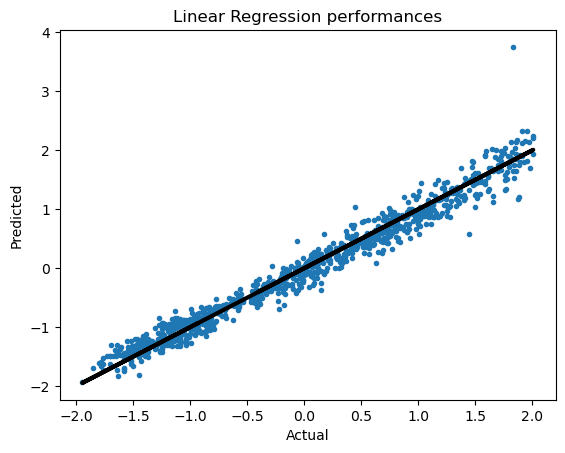

In [49]:
linear_regr = full_pipeline(preprocessor,diamonds,'LinearRegression','Linear Regression')

In [50]:
linear_regr

,MAE,R2
Linear Regression,0.1305,0.9681


### With Isolation Forest

[I 2024-07-01 12:32:42,689] A new study created in memory with name: Diamonds LinearRegression
[I 2024-07-01 12:32:42,704] Trial 0 finished with value: 0.15385655315638186 and parameters: {'fit_intercept': False}. Best is trial 0 with value: 0.15385655315638186.
[I 2024-07-01 12:32:42,707] Trial 1 finished with value: 0.15385655315638186 and parameters: {'fit_intercept': False}. Best is trial 0 with value: 0.15385655315638186.
[I 2024-07-01 12:32:42,717] Trial 2 finished with value: 0.14294782840702544 and parameters: {'fit_intercept': True}. Best is trial 2 with value: 0.14294782840702544.
[I 2024-07-01 12:32:42,724] Trial 3 finished with value: 0.15385655315638186 and parameters: {'fit_intercept': False}. Best is trial 2 with value: 0.14294782840702544.
[I 2024-07-01 12:32:42,729] Trial 4 finished with value: 0.14294782840702544 and parameters: {'fit_intercept': True}. Best is trial 2 with value: 0.14294782840702544.
[I 2024-07-01 12:32:42,738] Trial 5 finished with value: 0.15385655

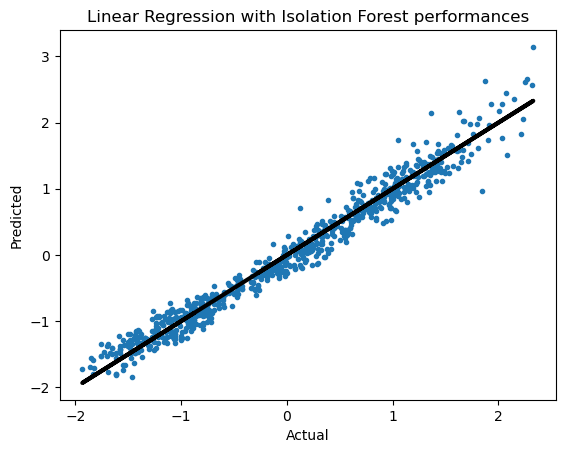

In [30]:
linear_regr_iso = full_pipeline(preprocessor_iso,diamonds,'LinearRegression','Linear Regression with Isolation Forest')

In [31]:
linear_regr_iso

,MAE,R2
Linear Regression with Isolation Forest,0.1429,0.966


### With PCA

[I 2024-07-01 12:33:09,087] A new study created in memory with name: Diamonds LinearRegression
[I 2024-07-01 12:33:09,090] Trial 0 finished with value: 0.3825267275928536 and parameters: {'fit_intercept': False}. Best is trial 0 with value: 0.3825267275928536.
[I 2024-07-01 12:33:09,098] Trial 1 finished with value: 0.3825267275928536 and parameters: {'fit_intercept': False}. Best is trial 0 with value: 0.3825267275928536.
[I 2024-07-01 12:33:09,102] Trial 2 finished with value: 0.4155037210917021 and parameters: {'fit_intercept': True}. Best is trial 0 with value: 0.3825267275928536.
[I 2024-07-01 12:33:09,107] Trial 3 finished with value: 0.3825267275928536 and parameters: {'fit_intercept': False}. Best is trial 0 with value: 0.3825267275928536.
[I 2024-07-01 12:33:09,110] Trial 4 finished with value: 0.4155037210917021 and parameters: {'fit_intercept': True}. Best is trial 0 with value: 0.3825267275928536.
[I 2024-07-01 12:33:09,119] Trial 5 finished with value: 0.3825267275928536 a

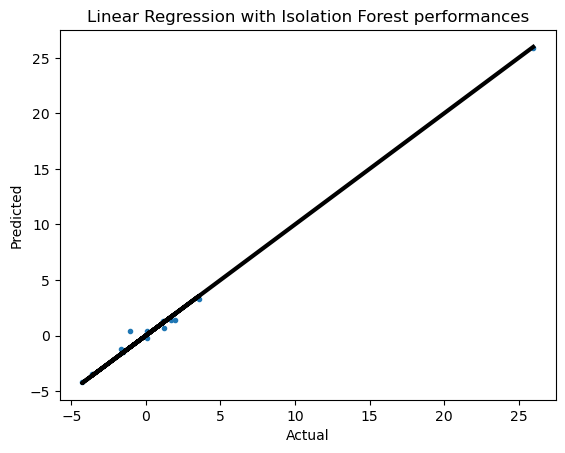

In [32]:
linear_regr_pca = full_pipeline(preprocessor_pca,diamonds,'LinearRegression','Linear Regression with Isolation Forest')

In [33]:
linear_regr_pca

,MAE,R2
Linear Regression with Isolation Forest,0.3825,0.995


### With PCA and Isolation Forest

[I 2024-07-01 12:33:20,180] A new study created in memory with name: Diamonds LinearRegression
[I 2024-07-01 12:33:20,196] Trial 0 finished with value: 0.2915065104324572 and parameters: {'fit_intercept': True}. Best is trial 0 with value: 0.2915065104324572.
[I 2024-07-01 12:33:20,201] Trial 1 finished with value: 0.28013466249691454 and parameters: {'fit_intercept': False}. Best is trial 1 with value: 0.28013466249691454.
[I 2024-07-01 12:33:20,206] Trial 2 finished with value: 0.2915065104324572 and parameters: {'fit_intercept': True}. Best is trial 1 with value: 0.28013466249691454.
[I 2024-07-01 12:33:20,213] Trial 3 finished with value: 0.2915065104324572 and parameters: {'fit_intercept': True}. Best is trial 1 with value: 0.28013466249691454.
[I 2024-07-01 12:33:20,216] Trial 4 finished with value: 0.28013466249691454 and parameters: {'fit_intercept': False}. Best is trial 1 with value: 0.28013466249691454.
[I 2024-07-01 12:33:20,224] Trial 5 finished with value: 0.2915065104324

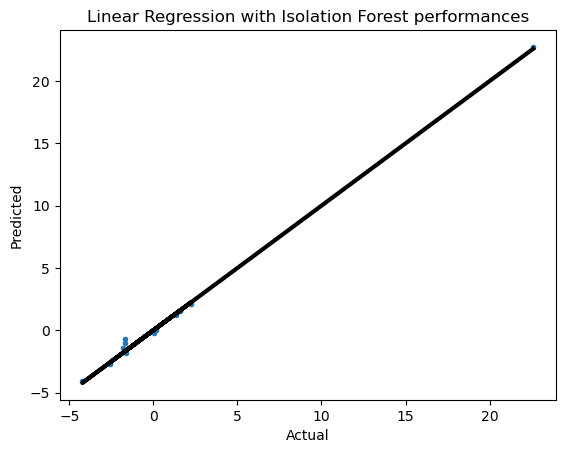

In [34]:
linear_regr_iso_pca = full_pipeline(preprocessor_iso_pca,diamonds,'LinearRegression','Linear Regression with Isolation Forest')

In [35]:
linear_regr_iso_pca

,MAE,R2
Linear Regression with Isolation Forest,0.2801,0.9965


### Discussion

Exploiting our preprocessing we get good results. Indeed, the log transformation and standardization helped in making everything at the same scale. We also employed Isolation Forest to remove outliers and make the optimization smoother. But, the effect of the outliers is very reduced given the dimension of the dataset. The latter is also the reason why the PCA is not working nicely, since there is no need to reduce the dataset again given the reduced dimensionality.

## XGBoost Pipeline

### Without Isolation forest

[I 2024-07-01 12:33:55,580] A new study created in memory with name: Diamonds XGBRegressor
[I 2024-07-01 12:33:55,764] Trial 0 finished with value: 0.8571819753218897 and parameters: {'lambda': 2.109245610087828e-07, 'alpha': 0.01572305286433874, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 9.682248430971036e-07, 'n_estimators': 237, 'max_depth': 4, 'min_child_weight': 3}. Best is trial 0 with value: 0.8571819753218897.
[I 2024-07-01 12:33:55,877] Trial 1 finished with value: 0.7333159181162224 and parameters: {'lambda': 0.004226755249504494, 'alpha': 0.002821820513961725, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.0015065695337545528, 'n_estimators': 163, 'max_depth': 5, 'min_child_weight': 5}. Best is trial 1 with value: 0.7333159181162224.
[I 2024-07-01 12:33:56,193] Trial 2 finished with value: 0.7222329709149176 and parameters: {'lambda': 0.001041068868364426, 'alpha': 0.021950998373512713, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate

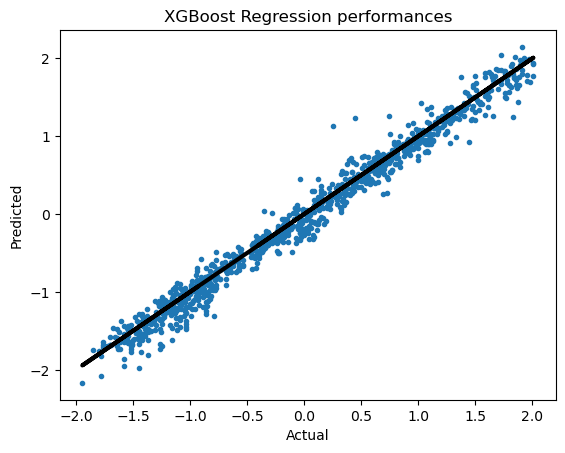

In [38]:
xgb_regr= full_pipeline(preprocessor,diamonds,'XGBRegressor','XGBoost Regression')

In [144]:
xgb_regr

,MAE,R2
XGBoost Regression,0.1216,0.9717


### With Isolation Forest

[I 2024-07-01 12:34:53,986] A new study created in memory with name: Diamonds XGBRegressor
[I 2024-07-01 12:34:54,231] Trial 0 finished with value: 0.17124317650718082 and parameters: {'lambda': 6.756080613477843e-08, 'alpha': 0.0005435967826015623, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.021340542581790297, 'n_estimators': 302, 'max_depth': 4, 'min_child_weight': 3}. Best is trial 0 with value: 0.17124317650718082.
[I 2024-07-01 12:34:54,880] Trial 1 finished with value: 0.8598628644240871 and parameters: {'lambda': 3.3256212560335956e-07, 'alpha': 0.005454691298138812, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 1.1765998554029838e-07, 'n_estimators': 425, 'max_depth': 7, 'min_child_weight': 7}. Best is trial 0 with value: 0.17124317650718082.
[I 2024-07-01 12:34:55,631] Trial 2 finished with value: 0.6444910272175034 and parameters: {'lambda': 2.170768110472663e-07, 'alpha': 0.00023173953772494184, 'colsample_bytree': 0.7, 'subsample': 0.8, 'lea

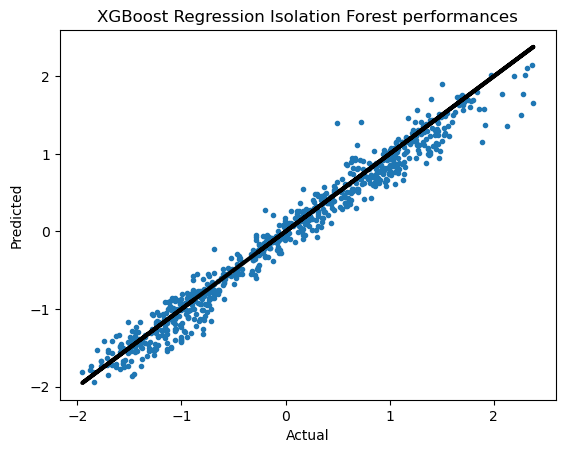

In [39]:
xgb_regr_iso = full_pipeline(preprocessor_iso,diamonds,'XGBRegressor','XGBoost Regression Isolation Forest')

In [40]:
xgb_regr_iso

,MAE,R2
XGBoost Regression Isolation Forest,0.1388,0.9657


In [147]:
xgb_regr = xgb_regr.append(xgb_regr_iso)

C:\Users\len\AppData\Local\Temp\ipykernel_16208\840364049.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgb_regr = xgb_regr.append(xgb_regr_iso)


### With PCA

[I 2024-07-01 12:36:37,220] A new study created in memory with name: Diamonds XGBRegressor
[I 2024-07-01 12:36:37,332] Trial 0 finished with value: 4.812746164398352 and parameters: {'lambda': 0.00229154541461969, 'alpha': 3.2297747936332717e-07, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 6.800732184350656e-08, 'n_estimators': 186, 'max_depth': 7, 'min_child_weight': 6}. Best is trial 0 with value: 4.812746164398352.
[I 2024-07-01 12:36:37,586] Trial 1 finished with value: 4.811599426052545 and parameters: {'lambda': 0.011962852466600777, 'alpha': 1.1881567815053138e-05, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 7.672043047801244e-07, 'n_estimators': 366, 'max_depth': 5, 'min_child_weight': 1}. Best is trial 1 with value: 4.811599426052545.
[I 2024-07-01 12:36:37,728] Trial 2 finished with value: 5.064232667559268 and parameters: {'lambda': 0.00015030809814706178, 'alpha': 0.014110258393918917, 'colsample_bytree': 0.4, 'subsample': 0.9, 'learning_rate

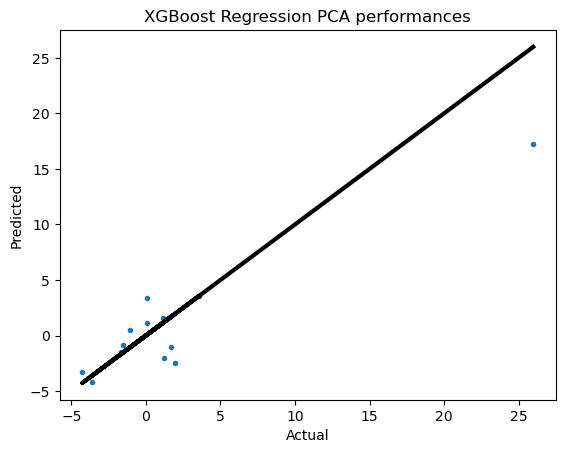

In [41]:
xgb_regr_pca = full_pipeline(preprocessor_pca,diamonds,'XGBRegressor', 'XGBoost Regression PCA')

In [42]:
xgb_regr_pca

,MAE,R2
XGBoost Regression PCA,2.1406,0.8129


In [148]:
xgb_regr = xgb_regr.append(xgb_regr_pca) 

C:\Users\len\AppData\Local\Temp\ipykernel_16208\3854828237.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgb_regr = xgb_regr.append(xgb_regr_pca)


### WIth Isolation Forest and PCA

[I 2024-07-01 12:37:11,662] A new study created in memory with name: Diamonds XGBRegressor
[I 2024-07-01 12:37:11,781] Trial 0 finished with value: 4.812784568129478 and parameters: {'lambda': 0.00012393977330337166, 'alpha': 0.0026393418833886638, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 4.6256264085531937e-08, 'n_estimators': 252, 'max_depth': 7, 'min_child_weight': 7}. Best is trial 0 with value: 4.812784568129478.
[I 2024-07-01 12:37:12,022] Trial 1 finished with value: 4.8139495546665305 and parameters: {'lambda': 0.0030470755047949088, 'alpha': 0.005606829616545813, 'colsample_bytree': 0.7, 'subsample': 0.9, 'learning_rate': 6.776230538589647e-06, 'n_estimators': 701, 'max_depth': 9, 'min_child_weight': 9}. Best is trial 0 with value: 4.812784568129478.
[I 2024-07-01 12:37:12,305] Trial 2 finished with value: 4.793743396688766 and parameters: {'lambda': 0.38460009135766854, 'alpha': 0.20655345987131596, 'colsample_bytree': 0.3, 'subsample': 0.9, 'learning_rate'

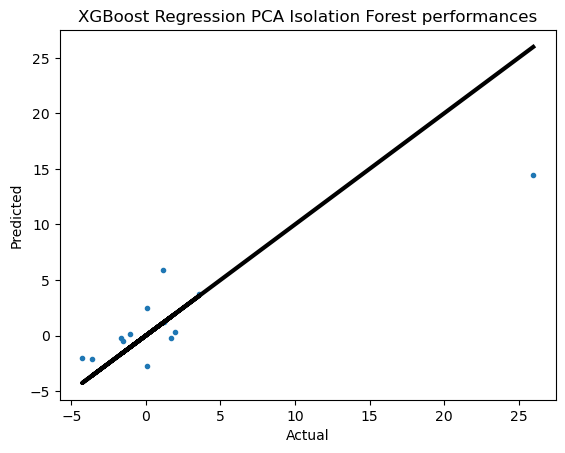

In [43]:
xgb_regr_pca_iso = full_pipeline(preprocessor_pca,diamonds,'XGBRegressor','XGBoost Regression PCA Isolation Forest')

In [152]:
xgb_regr_pca_iso

,MAE,R2
XGBoost Regression PCA Isolation Forest,3.7024,-0.1361


In [153]:
xgb_regr = xgb_regr.append(xgb_regr_pca_iso) 

C:\Users\len\AppData\Local\Temp\ipykernel_16208\3091165934.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgb_regr = xgb_regr.append(xgb_regr_pca_iso)


### Performances

In [154]:
xgb_regr

,MAE,R2
XGBoost Regression,0.1216,0.9717
XGBoost Regression Isolation Forest,0.1121,0.9776
XGBoost Regression PCA,3.7024,-0.1361
XGBoost Regression PCA Isolation Forest,3.7024,-0.1361


### Discussion

## Ridge Regression Pipeline

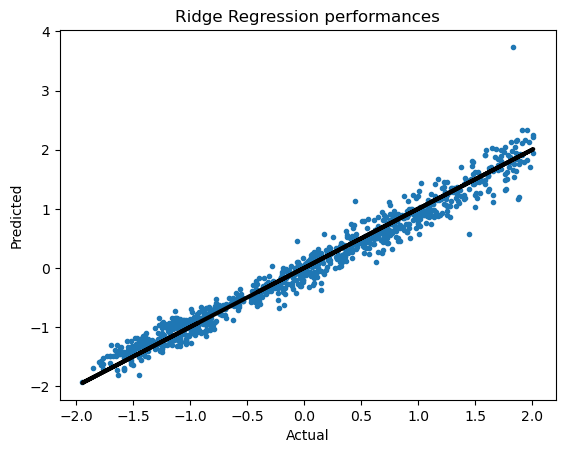

In [75]:
ridge_regr_no_iso = full_pipeline(preprocessor_no_iso,diamonds,'RidgeRegression',
                                'Ridge Regression')

In [76]:
ridge_regr_no_iso

,MAE,R2
Ridge Regression,0.1314,0.9677


### With Isolation Forest

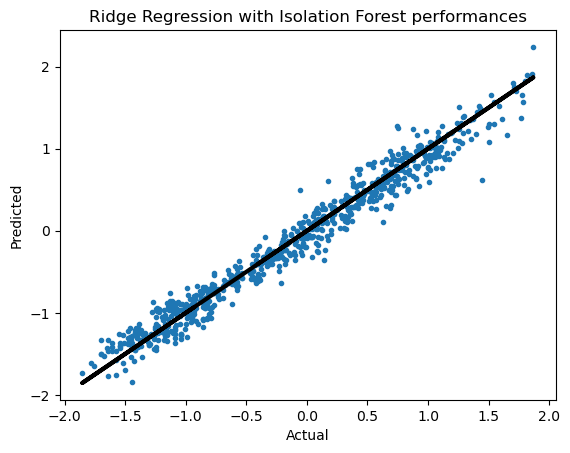

In [77]:
ridge_regr_iso = full_pipeline(preprocessor_iso,diamonds,Ridge(),
                                'Ridge Regression with Isolation Forest')

In [78]:
ridge_regr_iso

,MAE,R2
Ridge Regression with Isolation Forest,0.1233,0.9668
